In [89]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

FEATURE_COLS = [
    'pitch_count', 'num_pitch_types', 'max_inning',
    'rest_days', 'rolling_K_avg_3', 'rolling_K_avg_5',
    'rolling_pitch_count_5', 'rolling_K_rate',
    'opponent_k_pct', 'park_factor_K'
]
TARGET_COL = 'strikeouts'
TRAIN_SEASONS = [2021, 2022, 2023]
TEST_SEASON = 2024

In [90]:
train_dfs = [
    pd.read_parquet(f"../data/processed/pitcher_game_data_{yr}.parquet")
    for yr in TRAIN_SEASONS
]
train_df = pd.concat(train_dfs, ignore_index=True)
print(f"▶️ Training on seasons {TRAIN_SEASONS}: {train_df.shape[0]} rows")

test_df = pd.read_parquet(f"../data/processed/pitcher_game_data_{TEST_SEASON}.parquet")
print(f"▶️ Testing on season {TEST_SEASON}: {test_df.shape[0]} rows")


print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head(100)

▶️ Training on seasons [2021, 2022, 2023]: 2673 rows
▶️ Testing on season 2024: 873 rows
Train shape: (2673, 18)
Test shape: (873, 18)


,game_date,pitch_count,strikeouts,max_inning,num_pitch_types,home_team,away_team,rest_days,pitcher_team,opponent_team,opponent_k_pct,park_factor_K,rolling_K_avg_3,rolling_K_avg_5,rolling_pitch_count_5,rolling_K_rate,pitcher_name,pitcher_id
0,2021-04-03,87,11,7,5,MIL,MIN,5,MIL,MIN,0.361702,1.03,5.000000,5.0,85.0,0.055000,Corbin Burnes,669203
1,2021-04-08,86,9,6,6,STL,MIL,5,MIL,STL,0.283186,0.97,5.000000,5.0,85.0,0.055000,Corbin Burnes,669203
2,2021-04-14,81,10,6,6,MIL,CHC,6,MIL,CHC,0.287958,1.03,5.000000,5.0,85.0,0.055000,Corbin Burnes,669203
3,2021-04-20,93,10,6,6,SD,MIL,6,MIL,SD,0.196816,1.01,10.000000,5.0,85.0,0.055000,Corbin Burnes,669203
4,2021-04-26,87,9,6,6,MIL,MIA,6,MIL,MIA,0.259928,1.03,9.666667,5.0,85.0,0.055000,Corbin Burnes,669203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2021-04-27,96,10,7,5,LAD,CIN,5,LAD,CIN,0.237089,1.00,5.666667,5.0,85.0,0.055000,Walker Buehler,621111
96,2021-05-05,92,8,6,6,CHC,LAD,8,LAD,CHC,0.268161,1.00,7.666667,6.2,94.0,0.048936,Walker Buehler,621111
97,2021-05-11,91,8,7,5,LAD,SEA,6,LAD,SEA,0.264800,1.00,9.000000,7.0,94.4,0.057203,Walker Buehler,621111
98,2021-05-17,98,7,7,5,LAD,ARI,6,LAD,ARI,0.230964,1.00,8.666667,7.8,94.6,0.054968,Walker Buehler,621111


In [91]:
X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]
X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET_COL]

print("Nulls in X_train:\n", X_train.isna().sum())
print("Nulls in X_test:\n", X_test.isna().sum())

Nulls in X_train:
 pitch_count              0
num_pitch_types          0
max_inning               0
rest_days                0
rolling_K_avg_3          0
rolling_K_avg_5          0
rolling_pitch_count_5    0
rolling_K_rate           0
opponent_k_pct           0
park_factor_K            0
dtype: int64
Nulls in X_test:
 pitch_count              0
num_pitch_types          0
max_inning               0
rest_days                0
rolling_K_avg_3          0
rolling_K_avg_5          0
rolling_pitch_count_5    0
rolling_K_rate           0
opponent_k_pct           0
park_factor_K            0
dtype: int64


📊Compare Multiple Models

,MAE,RMSE
LinearRegression,1.757078,4.794680
Ridge,1.763451,4.842837
XG Boost,1.988750,6.082780


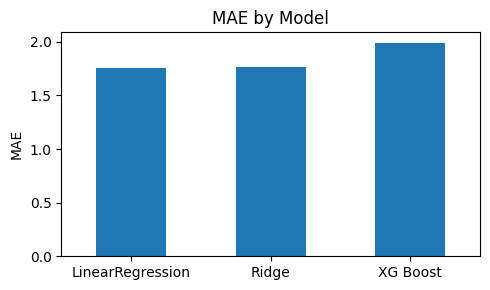

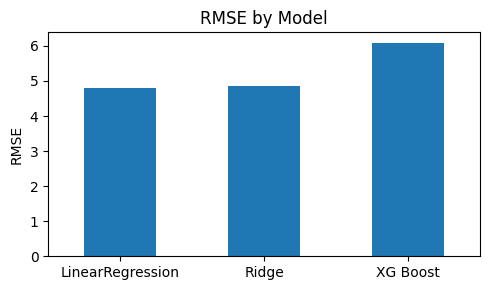

In [92]:
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "XG Boost": XGBRegressor(objective="reg:squarederror", n_estimators=100, verbosity=0)
}

results = {}
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    p = mdl.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, p),
        "RMSE": mean_squared_error(y_test, p)
    }

# Display results
res_df = pd.DataFrame(results).T
display(res_df)

for metric in ["MAE", "RMSE"]:
    plt.figure(figsize=(5, 3))
    res_df[metric].plot(kind="bar")
    plt.title(f"{metric} by Model")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

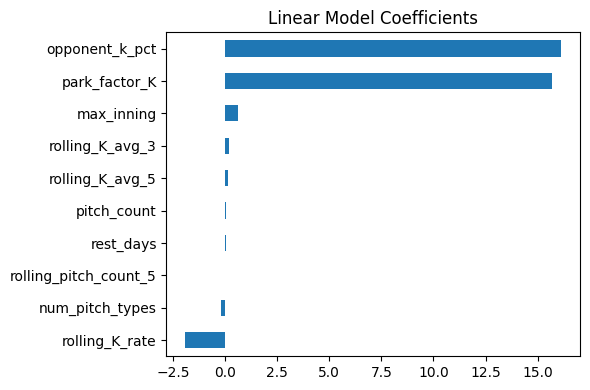

In [93]:
coefs = pd.Series(model.coef_, index=FEATURE_COLS).sort_values()
coefs.plot(kind='barh', figsize=(6, 4))
plt.title("Linear Model Coefficients")
plt.tight_layout()
plt.show()

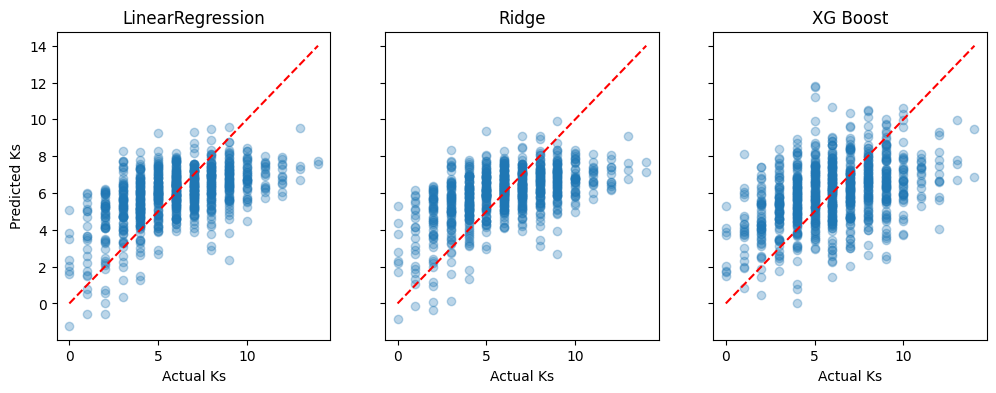

In [94]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
for ax, (name, mdl) in zip(axes, models.items()):
    p = mdl.predict(X_test)
    ax.scatter(y_test, p, alpha=0.3)
    ax.plot([0, max(y_test.max(), p.max())], [0, max(y_test.max(), p.max())], 'r--')
    ax.set_title(name)
    ax.set_xlabel("Actual Ks")
axes[0].set_ylabel("Predicted Ks")
plt.tight_layout
plt.show()

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

tscv = TimeSeriesSplit(n_splits=3)
baseline = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42),
    "XGB_Default": XGBRegressor(objective="reg:squarederror", n_estimators=100, verbosity=0)
}

cv_metrics = {}
for name, mdl in baseline.items():
    scores = cross_val_score(mdl, X_train, y_train,
                             cv=tscv, scoring="neg_mean_absolute_error")
    cv_metrics[name] = {
        "CV_MAE": -scores.mean(),
        "CV_Std": scores.std()
    }
cv_df = pd.DataFrame(cv_metrics).T

In [96]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.2],
}
xgb_pois = XGBRegressor(objective='count:poisson', verbosity=0)
grid = GridSearchCV(xgb_pois, param_grid, cv=tscv,
                    scoring="neg_mean_absolute_error", n_jobs=-1)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_
cv_df.loc["XGB_Tuned"] = {
    "CV_MAE": -grid.best_score_,
    "CV_Std": grid.cv_results_['std_test_score'][grid.best_index_]
}
print("🏆 XGB Best Params:", grid.best_params_)

🏆 XGB Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [97]:
eval_metrics = {}
for name, mdl in {**baseline, "XGB_Tuned": best_xgb}.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    eval_metrics[name] = {
        "Test_MAE": mean_absolute_error(y_test, preds),
        "Test_RMSE": mean_squared_error(y_test, preds)
    }
eval_metrics = pd.DataFrame(eval_metrics).T

results = cv_df.join(eval_metrics)
display(results)

,CV_MAE,CV_Std,Test_MAE,Test_RMSE
Linear,1.807274,0.068319,1.757078,4.794680
Ridge,1.832659,0.074296,1.763451,4.842837
RandomForest,1.857812,0.069392,1.820301,5.048896
XGB_Default,2.019877,0.079403,1.988750,6.082780
XGB_Tuned,1.849949,0.103311,1.796933,4.999269


In [100]:
import os

metrics_dir = "../data/metrics"
metrics_path = os.path.join(metrics_dir, "2021-2023_vs_2024_metrics.csv")
results.to_csv(metrics_path, index=True)

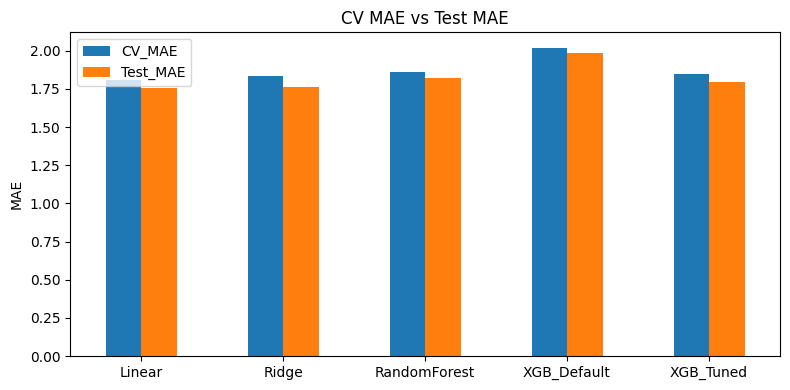

In [98]:
results[["CV_MAE", "Test_MAE"]].plot(
    kind="bar", figsize=(8,4), title="CV MAE vs Test MAE"
)
plt.ylabel("MAE")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

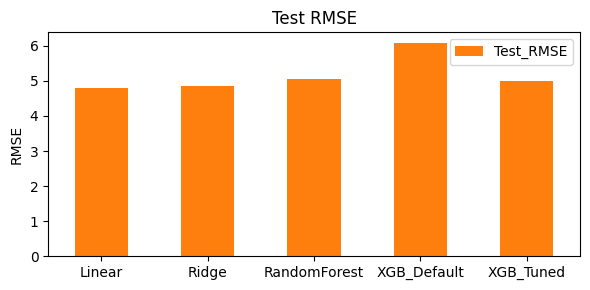

In [99]:
results[["Test_RMSE"]].plot(
    kind="bar", figsize=(6,3), color="C1", title="Test RMSE"
)
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()